## Clean (including outliers) and merge: 
    -Local Law 84 data 
    -PLUTO data 
    -Census data 
    -other datasets as needed

1. Grab, clean LL84 2016 data

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import geopandas as gpd
import os
import zipfile
import urllib
import urllib2
import StringIO
from fiona.crs import from_epsg
import shapely
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
Benchmark = pd.read_excel(
    "Data/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx",
    sheetname=0, header=0)

    3. Histogram of weather-normalized source EUI, with mean, median, and std dev

In [3]:
print("Standard Deviation: ", Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].std())
print("Mean: ", Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].mean())
print("Median: ", Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].median())

('Standard Deviation: ', 9761.9906181734659)
('Mean: ', 527.60575751421607)
('Median: ', 82.5)


In [4]:
Benchmark = Benchmark.sort(['Weather Normalized Site EUI (kBtu/ft^2)', 'Record Number'], ascending=[1, 0])
Benchmark = Benchmark[pd.notnull(Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'])]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [5]:
#Remove outliers more than 3 standard deviations away from the mean in either direction.
Benchmark = Benchmark[Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'] 
                < (Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].mean())
                + (Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].std()*3)]
Benchmark = Benchmark[Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'] 
                > (Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].mean())
                - (Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'].std()*3)]
Benchmark = Benchmark[Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'] != 0]

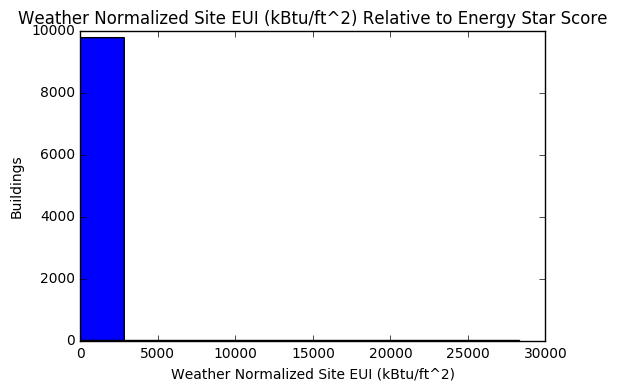

In [6]:
pl.title("Weather Normalized Site EUI (kBtu/ft^2) Relative to Energy Star Score")
pl.hist(Benchmark['Weather Normalized Site EUI (kBtu/ft^2)'], bins = 10)
pl.ylabel('Buildings')
pl.xlabel('Weather Normalized Site EUI (kBtu/ft^2)')

- Pot Energy Star Score v. Source EUI

In [7]:
#Removing Outliers from Source EUI 
#Be = result[result['Source EUI (kBtu/ft^2)'] < 19000]

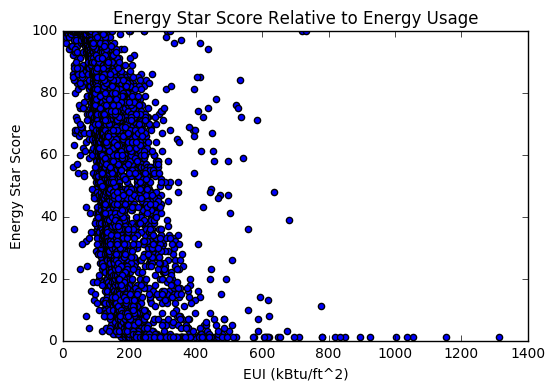

In [8]:
pl.title("Energy Star Score Relative to Energy Usage")
pl.xlabel("EUI (kBtu/ft^2)")
pl.ylabel("Energy Star Score")
pl.xlim(0, 1400)
pl.ylim(0,100)
pl.scatter(Benchmark['Source EUI (kBtu/ft^2)'], Benchmark['ENERGY STAR Score'])

## <center>Import Pluto Data</center>

In [9]:
#Accessing PLUTO data through CartoDB. 
#Reference available here: https://github.com/CartoDB/cartodb-pluto

boros_dict = ['bk', 'qns', 'bx', 'man', 'si']
q_format="CSV"
LIMIT = ""

bk_q = "SELECT * FROM bk_mappluto_13v1" + LIMIT
qns_q = "SELECT * FROM qn_mappluto_13v1" + LIMIT
bx_q = "SELECT * FROM bx_mappluto_13v1" + LIMIT
man_q = "SELECT * FROM mn_mappluto_13v1" + LIMIT
si_q = "SELECT * FROM si_mappluto_13v1" + LIMIT

bk_q = bk_q.replace(" ", "%20")
qns_q = qns_q.replace(" ", "%20")
bx_q = bx_q.replace(" ", "%20")
man_q = man_q.replace(" ", "%20")
si_q = si_q.replace(" ", "%20")

In [10]:
#Import BBL files form Cartodb

bk_bbl = pd.read_csv("https://pluto.cartodb.com/api/v2/sql?q=" + bk_q + "&format=" + q_format,
                 converters={'ct2010': str})
qns_bbl = pd.read_csv("https://pluto.cartodb.com/api/v2/sql?q=" + qns_q + "&format=" + q_format,
                 converters={'ct2010': str})
bx_bbl = pd.read_csv("https://pluto.cartodb.com/api/v2/sql?q=" + bx_q + "&format=" + q_format,
                 converters={'ct2010': str})
si_bbl = pd.read_csv("https://pluto.cartodb.com/api/v2/sql?q=" + si_q + "&format=" + q_format)
man_bbl = pd.read_csv("https://pluto.cartodb.com/api/v2/sql?q=" + man_q + "&format=" + q_format,
                 converters={'ct2010': str})

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14,15,17,18,20,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14,15,17,18,61,62,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (

In [11]:
#Pare down dataframes to select information from each table. 
man_bbl = man_bbl[['address', 'borough','bbl', 'cd', 'ct2010', 'borocode', 'zipcode']]
qns_bbl = qns_bbl[['address', 'borough', 'bbl', 'cd', 'ct2010', 'borocode', 'zipcode']]
bk_bbl = bk_bbl[['address', 'borough', 'bbl', 'cd', 'ct2010', 'borocode', 'zipcode']]
si_bbl = si_bbl[['address', 'borough', 'bbl', 'cd', 'ct2010', 'borocode', 'zipcode']]
bx_bbl = bx_bbl[['address', 'borough', 'bbl', 'cd', 'ct2010', 'borocode', 'zipcode']]

# <center>-- WORK ON STATEN ISLAND --

In [12]:
si_bbl = si_bbl.dropna(subset=['ct2010'])
si_bbl['ct2010_int'] = si_bbl['ct2010'].map(int)
si_bbl['theory']=si_bbl.ct2010-si_bbl.ct2010_int

In [13]:
def si_ct_formatter(row): 
    if ((row['theory']) == 0):
        return (row['ct2010'].replace(".", "")+("0"))
    if ((row['theory']) != 0):
        return (row['ct2010'].zfill(6).replace(".", ""))
    else: 
        return 0

In [14]:
si_bbl.ct2010 = si_bbl.ct2010.astype(str)
si_bbl['ct2010'] = si_bbl.apply(si_ct_formatter, axis=1)
si_bbl['ct2010'] = si_bbl.borocode.astype(str) + si_bbl['ct2010'].str.zfill(6)
si_bbl = si_bbl[['address', 'borough', 'bbl', 'cd', 'ct2010', 'borocode', 'zipcode']]

In [15]:
si_bbl.head(30)

,address,borough,bbl,cd,ct2010,borocode,zipcode
1,OSGOOD AVENUE,SI,5.029250e+09,501,5004000,5,10304
5,58 GRANITE AVENUE,SI,5.011510e+09,501,5022300,5,10303
6,95 HENDRICKS AVENUE,SI,5.000400e+09,501,5000900,5,10301
7,49 FOCH AVENUE,SI,5.032790e+09,502,5007000,5,10305
8,198 BEECHWOOD AVENUE,SI,5.000490e+09,501,5000900,5,10301
9,1086 BAY STREET,SI,5.028450e+09,501,5000800,5,10305
10,124 LYNHURST AVENUE,SI,5.028440e+09,501,5000800,5,10305
11,284 ATLANTIC AVENUE,SI,5.033330e+09,502,5009602,5,10305
12,18 ELIAS PLACE,SI,5.003561e+09,501,5015100,5,10314
13,244 LAWRENCE AVENUE,SI,5.002800e+09,501,5012100,5,10310


# <center>--WORK ON STATEN ISLAND--

In [16]:
#Convert BBL value from float to integer to string. 
man_bbl['bbl']=(man_bbl['bbl'].map(int)).map(str)
bk_bbl['bbl']=(bk_bbl['bbl'].map(int)).map(str)
qns_bbl['bbl']=(qns_bbl['bbl'].map(int)).map(str)
bx_bbl['bbl']=(bx_bbl['bbl'].map(int)).map(str)
si_bbl['bbl']=(si_bbl['bbl'].map(int)).map(str)
#si_bbl['ct2010']=si_bbl['ct2010']

#Combine boro-specific dataframes into one citywide table. 
nyc_bbl = bk_bbl.append(man_bbl, ignore_index=True).append(qns_bbl, ignore_index=True).append(bx_bbl, ignore_index=True)

#nyc_bbl['bbl']=(nyc_bbl['bbl'].map(int)).map(str)

In [17]:
#nyc_bbl = nyc_bbl.dropna(subset=['ct2010'])

In [18]:
#nyc_bbl['ct2010'] = nyc_bbl.ct2010.apply(str)

In [19]:
nyc_bbl

,address,borough,bbl,cd,ct2010,borocode,zipcode
0,288 CARROLL STREET,BK,3004500028,306,77,3,11231
1,332 BOND STREET,BK,3004370044,306,75,3,11231
2,94 BERGEN STREET,BK,3003850015,302,69,3,11201
3,494 13 STREET,BK,3011010030,306,167,3,11215
4,ST MARKS PLACE,BK,3009340016,306,129.01,3,11217
5,5603 2 AVENUE,BK,3008370008,307,22,3,11220
6,303 BOND STREET,BK,3004310002,306,75,3,11231
7,528 6 AVENUE,BK,3010420043,306,141,3,11215
8,573 4 AVENUE,BK,3010520006,307,141,3,11215
9,7510 10 AVENUE,BK,3059450047,310,206,3,11228


In [20]:
#Census Tract 	STATE+COUNTY+TRACT 	2+3+6=11 	Census Tract 2231 in Harris County, TX 	48201 "223100"
#https://www.census.gov/geo/reference/geoidentifiers.html
#http://stackoverflow.com/questions/23836277/add-leading-zeros-to-strings-in-pandas-dataframe
#http://stackoverflow.com/questions/23482304/python-pandas-data-frame-if-else-without-iterating-thought-data-frame

def ct_formatter(row): 
    if (len(row['ct2010']) > 3):
        return (row['ct2010'].zfill(7).replace(".", ""))
    elif (len(row['ct2010']) < 4):
        return (row['ct2010'].zfill(4))
    else: 
        return 0

In [21]:
#Format census tracts to six-digit style used by Census documentation. 
#Concatenate with Borocode to ensure each tract is unique. 

nyc_bbl['ct2010'] = nyc_bbl.apply(ct_formatter, axis=1)
nyc_bbl['ct2010'] = nyc_bbl.borocode.astype(str) + nyc_bbl['ct2010'].str.pad(side='right',width=6,fillchar='0')
nyc_bbl

,address,borough,bbl,cd,ct2010,borocode,zipcode
0,288 CARROLL STREET,BK,3004500028,306,3007700,3,11231
1,332 BOND STREET,BK,3004370044,306,3007500,3,11231
2,94 BERGEN STREET,BK,3003850015,302,3006900,3,11201
3,494 13 STREET,BK,3011010030,306,3016700,3,11215
4,ST MARKS PLACE,BK,3009340016,306,3012901,3,11217
5,5603 2 AVENUE,BK,3008370008,307,3002200,3,11220
6,303 BOND STREET,BK,3004310002,306,3007500,3,11231
7,528 6 AVENUE,BK,3010420043,306,3014100,3,11215
8,573 4 AVENUE,BK,3010520006,307,3014100,3,11215
9,7510 10 AVENUE,BK,3059450047,310,3020600,3,11228


In [22]:
#Add in Staten Island
nyc_bbl = nyc_bbl.append(si_bbl, ignore_index=True)

 <center>--</center>

 <center>--</center>

In [23]:
Benchmark.rename(columns = {'NYC Borough, Block and Lot (BBL)': 'bbl'}, inplace=True)
Benchmark = Benchmark[np.isfinite(Benchmark['bbl'])]
Benchmark['bbl'] = Benchmark['bbl'].map(int).map(str)

In [24]:
Benchmark.columns

Index([                                                   u'Record Number',
                                                                  u'Order',
                                                                    u'bbl',
                                                 u'Co-reported BBL Status',
                                                       u'BBLs Co-reported',
                    u'Reported NYC Building Identification Numbers (BINs)',
                                                          u'Property Name',
                                                     u'Parent Property Id',
                                                   u'Parent Property Name',
                                                          u'Street Number',
                                                            u'Street Name',
                                                               u'Zip Code',
                                                                u'Borough',
            

In [25]:
Benchmark = Benchmark[['bbl', 'Year Built',
                       'Primary Property Type - Self Selected','List of All Property Use Types at Property', 
                       'Site EUI (kBtu/ft^2)', 
                       'Weather Normalized Site EUI (kBtu/ft^2)',
                       'Total GHG Emissions (Metric Tons CO2e)', 'Borough', 
                       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
                       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)']]

#Benchmark['Total GHG Emissions (Metric Tons CO2e)']

#Benchmark[['Total GHG Emissions (Metric Tons CO2e)','Site EUI (kBtu/ft^2)', 'Occupancy',
#                      'ENERGY STAR Score', 'Weather Normalized Source EUI (kBtu/ft^2)',
#                      'Primary Property Type - Self Selected','List of All Property Use Types at Property',
#                      'Largest Property Use Type', 'Year Built']]

In [26]:
Benchmark.shape

(9790, 12)

In [27]:
#Join Benchmarking Data with BBL Data
Integrated = Benchmark.merge(nyc_bbl, how='left', on='bbl')
Integrated.dropna(inplace=True)

In [28]:
Integrated.head()

,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),address,borough,cd,ct2010,borocode,zipcode
0,1019900005,1909,Multifamily Housing,Multifamily Housing,0.1,0.1,0.2,Manhattan,Not Available,Not Available,Not Available,0,15 CLAREMONT AVENUE,MN,109.0,1020500,1.0,10027.0
1,1007880019,1924,Office,"Non-Refrigerated Warehouse, Office, Other",0.1,0.1,1.2,Manhattan,Not Available,Not Available,Not Available,Not Available,247 WEST 38 STREET,MN,105.0,1011300,1.0,10018.0
2,1019900044,1924,Residence Hall/Dormitory,Residence Hall/Dormitory,0.1,0.1,0.3,Manhattan,Not Available,Not Available,Not Available,Not Available,464 RIVERSIDE DRIVE,MN,109.0,1020500,1.0,10027.0
3,4002670009,2015,Multifamily Housing,"Multifamily Housing, Parking, Swimming Pool",0.2,0.2,5.4,Queens,Not Available,Not Available,Not Available,Not Available,44-35 PURVES STREET,QN,402.0,4001900,4.0,11101.0
5,3048200001,1960,Multifamily Housing,Multifamily Housing,0.2,0.2,1.3,Brooklyn,Not Available,Not Available,Not Available,Not Available,655 NEW YORK AVENUE,BK,309.0,3081000,3.0,11203.0


In [29]:
Integrated.sort(['Total GHG Emissions (Metric Tons CO2e)', 'Year Built'], ascending=[0, 1]).head(10)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),address,borough,cd,ct2010,borocode,zipcode
9779,1007390001,1932,Office,"Data Center, Medical Office, Office, Other - R...",17038.8,16887.0,3221505.2,Manhattan,Not Available,Not Available,Not Available,Not Available,103 8 AVENUE,MN,104.0,1008300,1.0,10011.0
9785,1000447501,1928,Multifamily Housing,Multifamily Housing,22813.3,22670.3,884422.7,Manhattan,Not Available,Not Available,Not Available,Not Available,18 PINE STREET,MN,101.0,1000700,1.0,10005.0
9778,1000420031,1911,Office,Office,16531.5,16338.2,579432.7,Manhattan,Not Available,Not Available,Not Available,Not Available,80 MAIDEN LANE,MN,101.0,1000700,1.0,10005.0
9786,1000537502,2010,Hotel,Hotel,22651.4,23062.6,474705.3,Manhattan,Not Available,Not Available,Not Available,Not Available,123 WASHINGTON STREET,MN,101.0,1001300,1.0,10006.0
9780,1000100016,1931,Office,Office,17938.1,18820.1,400500.0,Manhattan,Not Available,Not Available,Not Available,Not Available,90 BROAD STREET,MN,101.0,1000900,1.0,10004.0
9784,1012610034,1989,Office,"Bank Branch, Office",21691.4,21968.6,275051.3,Manhattan,Not Available,Not Available,Not Available,Not Available,546 5 AVENUE,MN,105.0,1009600,1.0,10036.0
9788,1007967504,2005,Multifamily Housing,Multifamily Housing,23960.2,24418.5,208837.0,Manhattan,Not Available,Not Available,Not Available,Not Available,655 AVENUE OF THE AMER,MN,104.0,1008700,1.0,10010.0
9782,1000680011,1925,Office,Office,20006.6,19800.6,206046.6,Manhattan,Not Available,Not Available,Not Available,Not Available,75 MAIDEN LANE,MN,101.0,1001502,1.0,10038.0
9789,1013490044,1928,Multifamily Housing,Multifamily Housing,27618.1,28318.5,201738.4,Manhattan,Not Available,Not Available,Not Available,Not Available,320 EAST 57 STREET,MN,106.0,1010800,1.0,10022.0
9777,4085150002,1948,Multifamily Housing,Multifamily Housing,15659.4,15663.6,133494.2,Queens,Not Available,0,Not Available,Not Available,74-02 260 STREET,QN,413.0,4155102,4.0,11004.0


In [30]:
#Import Census Data
Population = pd.read_excel(
    "http://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/t_pl_p5_ct.xlsx",
    sheetname=0, header=4)

Population = Population[['Geographic Area', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 2']]

In [31]:
Population.head()

,Geographic Area,Unnamed: 3,Unnamed: 5,Unnamed: 2
0,Borough,2010 Census Tract,2010.0,2010 DCP Borough Code
1,NaN,NaN,NaN,NaN
2,Bronx,000100,11091.0,2
3,Bronx,000200,4334.0,2
4,Bronx,000400,5503.0,2


In [32]:
Population.rename(columns = {'Geographic Area': 'Borough', 'Unnamed: 3': 'ct2010',
                            'Unnamed: 5': 'Population', 'Unnamed: 2': 'boro_code'}, inplace=True)

Population['ct2010'] = Population.boro_code.map(str)+Population.ct2010.map(str)

Population.head()

,Borough,ct2010,Population,boro_code
0,Borough,2010 DCP Borough Code2010 Census Tract,2010.0,2010 DCP Borough Code
1,NaN,nannan,NaN,NaN
2,Bronx,2000100,11091.0,2
3,Bronx,2000200,4334.0,2
4,Bronx,2000400,5503.0,2


In [33]:
#Join Population data to Integrated Table. 
Integrated = Integrated.merge(Population, how='left', on="ct2010")
Integrated.shape

(9674, 21)

In [34]:
Integrated.head()

,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough_x,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),...,Fuel Oil #5 & 6 Use (kBtu),address,borough,cd,ct2010,borocode,zipcode,Borough_y,Population,boro_code
0,1019900005,1909,Multifamily Housing,Multifamily Housing,0.1,0.1,0.2,Manhattan,Not Available,Not Available,...,0,15 CLAREMONT AVENUE,MN,109.0,1020500,1.0,10027.0,Manhattan,5322.0,1
1,1007880019,1924,Office,"Non-Refrigerated Warehouse, Office, Other",0.1,0.1,1.2,Manhattan,Not Available,Not Available,...,Not Available,247 WEST 38 STREET,MN,105.0,1011300,1.0,10018.0,Manhattan,117.0,1
2,1019900044,1924,Residence Hall/Dormitory,Residence Hall/Dormitory,0.1,0.1,0.3,Manhattan,Not Available,Not Available,...,Not Available,464 RIVERSIDE DRIVE,MN,109.0,1020500,1.0,10027.0,Manhattan,5322.0,1
3,4002670009,2015,Multifamily Housing,"Multifamily Housing, Parking, Swimming Pool",0.2,0.2,5.4,Queens,Not Available,Not Available,...,Not Available,44-35 PURVES STREET,QN,402.0,4001900,4.0,11101.0,Queens,1076.0,4
4,3048200001,1960,Multifamily Housing,Multifamily Housing,0.2,0.2,1.3,Brooklyn,Not Available,Not Available,...,Not Available,655 NEW YORK AVENUE,BK,309.0,3081000,3.0,11203.0,Brooklyn,2300.0,3


In [35]:
#Import Income Data
#https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_15_5YR_B19001&prodType=table

Income = pd.read_csv("Data/Income Clean.csv", header=0)

Income = Income[['Geography', 'Census Tract', 'Low-Income', 'Middle-Income', 
                 'High-Income', 'Pct. Low Income', 'Pct. Miiddle Income', 'Pct. High Income']]

Income.rename(columns = {'Census Tract': 'ct2010'}, inplace=True)

Income.head()

,Geography,ct2010,Low-Income,Middle-Income,High-Income,Pct. Low Income,Pct. Miiddle Income,Pct. High Income
0,"Census Tract 1, Bronx County, New York",2000100,0,0,0,0.00%,0.00%,0.00%
1,"Census Tract 2, Bronx County, New York",2000200,463,806,276,29.97%,52.17%,17.86%
2,"Census Tract 4, Bronx County, New York",2000400,558,1189,295,27.33%,58.23%,14.45%
3,"Census Tract 16, Bronx County, New York",2001600,1265,635,90,63.57%,31.91%,4.52%
4,"Census Tract 19, Bronx County, New York",2001900,575,309,22,63.47%,34.11%,2.43%


In [36]:
#Import Asthma Rates

Asthma = pd.read_excel(
    "Data/Asthma Rates (2012-2014).xlsx",
    sheetname=0, header=0)

Asthma.rename(columns = {'ZIP Code': 'zipcode'}, inplace=True)

Asthma.head()

,zipcode,ED Visits (2012-2014),ED Visit Rate
0,10001,794,109.1
1,10002,2799,113.2
2,10003,878,52.0
3,10004,19,17.0
4,10005,23,8.3


In [37]:
Integrated.zipcode=(Integrated.zipcode.map(int)).map(str)
Asthma['zipcode']=(Asthma['zipcode'].map(int)).map(str)

In [38]:
Integrated.head()

,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough_x,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),...,Fuel Oil #5 & 6 Use (kBtu),address,borough,cd,ct2010,borocode,zipcode,Borough_y,Population,boro_code
0,1019900005,1909,Multifamily Housing,Multifamily Housing,0.1,0.1,0.2,Manhattan,Not Available,Not Available,...,0,15 CLAREMONT AVENUE,MN,109.0,1020500,1.0,10027,Manhattan,5322.0,1
1,1007880019,1924,Office,"Non-Refrigerated Warehouse, Office, Other",0.1,0.1,1.2,Manhattan,Not Available,Not Available,...,Not Available,247 WEST 38 STREET,MN,105.0,1011300,1.0,10018,Manhattan,117.0,1
2,1019900044,1924,Residence Hall/Dormitory,Residence Hall/Dormitory,0.1,0.1,0.3,Manhattan,Not Available,Not Available,...,Not Available,464 RIVERSIDE DRIVE,MN,109.0,1020500,1.0,10027,Manhattan,5322.0,1
3,4002670009,2015,Multifamily Housing,"Multifamily Housing, Parking, Swimming Pool",0.2,0.2,5.4,Queens,Not Available,Not Available,...,Not Available,44-35 PURVES STREET,QN,402.0,4001900,4.0,11101,Queens,1076.0,4
4,3048200001,1960,Multifamily Housing,Multifamily Housing,0.2,0.2,1.3,Brooklyn,Not Available,Not Available,...,Not Available,655 NEW YORK AVENUE,BK,309.0,3081000,3.0,11203,Brooklyn,2300.0,3


In [39]:
Integrated = Integrated.merge(Asthma, how='left', on="zipcode")
Integrated.shape

(9674, 23)

In [40]:
Income.ct2010=(Income.ct2010.map(int).map(str))
Integrated = Integrated.merge(Income, how='left', on="ct2010")
Integrated.head()

,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough_x,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),...,boro_code,ED Visits (2012-2014),ED Visit Rate,Geography,Low-Income,Middle-Income,High-Income,Pct. Low Income,Pct. Miiddle Income,Pct. High Income
0,1019900005,1909,Multifamily Housing,Multifamily Housing,0.1,0.1,0.2,Manhattan,Not Available,Not Available,...,1,5010.0,273.3,"Census Tract 205, New York County, New York",204.0,515.0,552.0,16.05%,40.52%,43.43%
1,1007880019,1924,Office,"Non-Refrigerated Warehouse, Office, Other",0.1,0.1,1.2,Manhattan,Not Available,Not Available,...,1,84.0,44.5,"Census Tract 113, New York County, New York",18.0,28.0,26.0,25.00%,38.89%,36.11%
2,1019900044,1924,Residence Hall/Dormitory,Residence Hall/Dormitory,0.1,0.1,0.3,Manhattan,Not Available,Not Available,...,1,5010.0,273.3,"Census Tract 205, New York County, New York",204.0,515.0,552.0,16.05%,40.52%,43.43%
3,4002670009,2015,Multifamily Housing,"Multifamily Housing, Parking, Swimming Pool",0.2,0.2,5.4,Queens,Not Available,Not Available,...,4,1384.0,162.3,"Census Tract 19, Queens County, New York",161.0,476.0,373.0,15.94%,47.13%,36.93%
4,3048200001,1960,Multifamily Housing,Multifamily Housing,0.2,0.2,1.3,Brooklyn,Not Available,Not Available,...,3,4235.0,179.4,"Census Tract 810, Kings County, New York",489.0,338.0,100.0,52.75%,36.46%,10.79%


In [41]:
Integrated.sort(['Total GHG Emissions (Metric Tons CO2e)', 'bbl'], ascending=[0, 1]).head(4)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough_x,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),...,boro_code,ED Visits (2012-2014),ED Visit Rate,Geography,Low-Income,Middle-Income,High-Income,Pct. Low Income,Pct. Miiddle Income,Pct. High Income
9663,1007390001,1932,Office,"Data Center, Medical Office, Office, Other - R...",17038.8,16887.0,3221505.2,Manhattan,Not Available,Not Available,...,1,588.0,37.5,"Census Tract 83, New York County, New York",807.0,659.0,661.0,37.94%,30.98%,31.08%
9669,1000447501,1928,Multifamily Housing,Multifamily Housing,22813.3,22670.3,884422.7,Manhattan,Not Available,Not Available,...,1,23.0,8.3,"Census Tract 7, New York County, New York",810.0,2184.0,2087.0,15.94%,42.98%,41.07%
9662,1000420031,1911,Office,Office,16531.5,16338.2,579432.7,Manhattan,Not Available,Not Available,...,1,23.0,8.3,"Census Tract 7, New York County, New York",810.0,2184.0,2087.0,15.94%,42.98%,41.07%
9670,1000537502,2010,Hotel,Hotel,22651.4,23062.6,474705.3,Manhattan,Not Available,Not Available,...,1,15.0,13.1,"Census Tract 13, New York County, New York",355.0,1122.0,1158.0,13.47%,42.58%,43.95%


In [42]:
#Remove outliers more than 3 standard deviations away from the mean in either direction.
#Integrated = Integrated[Integrated['Weather Normalized '] 
#                < (Integrated['Total GHG Emissions (Metric Tons CO2e)'].mean())
#                + (Integrated['Total GHG Emissions (Metric Tons CO2e)'].std()*3)]
#Integrated = Integrated[Integrated['Total GHG Emissions (Metric Tons CO2e)'] 
#                > (Integrated['Total GHG Emissions (Metric Tons CO2e)'].mean())
#                - (Integrated['Total GHG Emissions (Metric Tons CO2e)'].std()*3)]

## <center>Assumption: Older buildings cause more Green House gas Emissions</center>

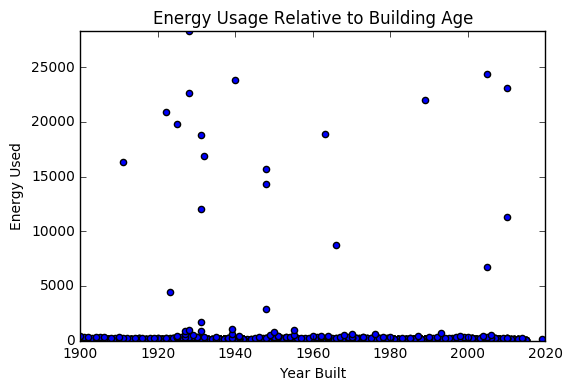

In [43]:
#Assumption: 
pl.title("Energy Usage Relative to Building Age")
pl.xlabel("Year Built")
pl.ylabel("Energy Used")
pl.xlim(1900, 2020)
pl.ylim(0,Integrated['Weather Normalized Site EUI (kBtu/ft^2)'].max()+50)
pl.scatter(Integrated['Year Built'], Integrated['Weather Normalized Site EUI (kBtu/ft^2)'])

## <center>Assumption: Green House Gas Emitting Buildings Are Concentrated in Low Income Areas</center>

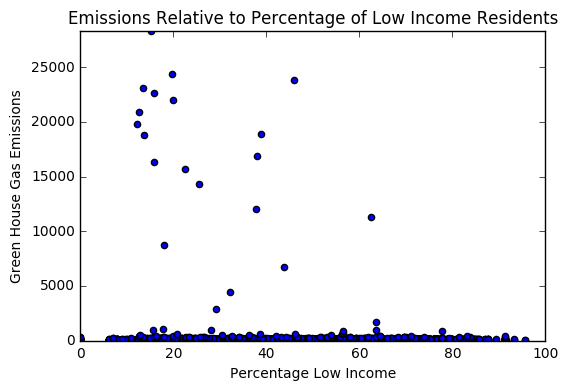

In [44]:
pl.title("Emissions Relative to Percentage of Low Income Residents")
pl.xlabel("Percentage Low Income")
pl.ylabel("Green House Gas Emissions")
pl.xlim(0, 100)
pl.ylim(0,Integrated['Weather Normalized Site EUI (kBtu/ft^2)'].max()+50)
pl.scatter(Integrated['Pct. Low Income'].str.replace("%", "").astype(float),
           Integrated['Weather Normalized Site EUI (kBtu/ft^2)'])

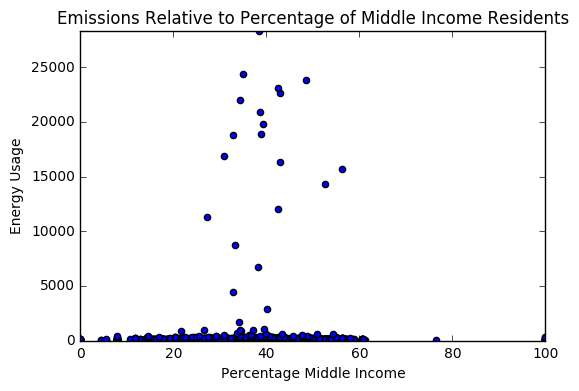

In [45]:
pl.title("Emissions Relative to Percentage of Middle Income Residents")
pl.xlabel("Percentage Middle Income")
pl.ylabel("Energy Usage")
pl.xlim(0, 100)
pl.ylim(0,Integrated['Weather Normalized Site EUI (kBtu/ft^2)'].max()+50)
pl.scatter(Integrated['Pct. Miiddle Income'].str.replace("%", "").astype(float),
           Integrated['Weather Normalized Site EUI (kBtu/ft^2)'])

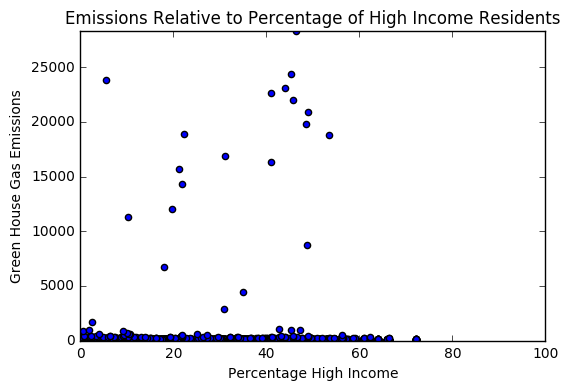

In [46]:
pl.title("Emissions Relative to Percentage of High Income Residents")
pl.xlabel("Percentage High Income")
pl.ylabel("Green House Gas Emissions")
pl.xlim(0, 100)
pl.ylim(0,Integrated['Weather Normalized Site EUI (kBtu/ft^2)'].max()+50)
pl.scatter(Integrated['Pct. High Income'].str.replace("%", "").astype(float),
           Integrated['Weather Normalized Site EUI (kBtu/ft^2)'])

## <center>Asthma Rates Are Higher in Zip Codes with High Polluting Buildings</center>

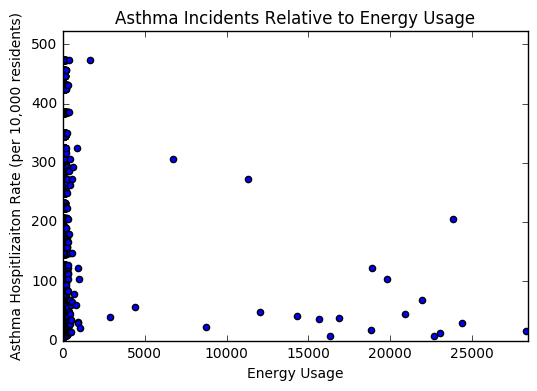

In [47]:
pl.title("Asthma Incidents Relative to Energy Usage")
pl.ylabel("Asthma Hospitlizaiton Rate (per 10,000 residents)")
pl.xlabel("Energy Usage")
pl.ylim(0,Integrated['ED Visit Rate'].max()+50)
pl.xlim(0,Integrated['Weather Normalized Site EUI (kBtu/ft^2)'].max()+100)
pl.scatter(Integrated['Weather Normalized Site EUI (kBtu/ft^2)'],
          Integrated['ED Visit Rate'],)

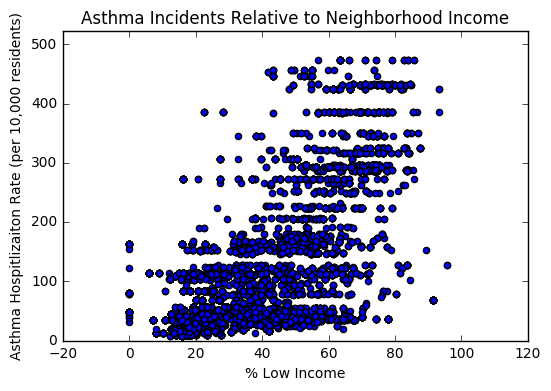

In [48]:
pl.title("Asthma Incidents Relative to Neighborhood Income")
pl.ylabel("Asthma Hospitlizaiton Rate (per 10,000 residents)")
pl.xlabel("% Low Income")
pl.ylim(0,Integrated['ED Visit Rate'].max()+50)
#pl.xlim(0,Integrated['Pct. Low Income'].max()+100)
pl.scatter(Integrated['Pct. Low Income'].str.replace("%", "").astype(float),
          Integrated['ED Visit Rate'])

## Residential Energy Usage

In [49]:
Residencies = Integrated[Integrated['Primary Property Type - Self Selected'] == 'Multifamily Housing']

In [50]:
Residencies.head()

,bbl,Year Built,Primary Property Type - Self Selected,List of All Property Use Types at Property,Site EUI (kBtu/ft^2),Weather Normalized Site EUI (kBtu/ft^2),Total GHG Emissions (Metric Tons CO2e),Borough_x,Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),...,boro_code,ED Visits (2012-2014),ED Visit Rate,Geography,Low-Income,Middle-Income,High-Income,Pct. Low Income,Pct. Miiddle Income,Pct. High Income
0,1019900005,1909,Multifamily Housing,Multifamily Housing,0.1,0.1,0.2,Manhattan,Not Available,Not Available,...,1,5010.0,273.3,"Census Tract 205, New York County, New York",204.0,515.0,552.0,16.05%,40.52%,43.43%
3,4002670009,2015,Multifamily Housing,"Multifamily Housing, Parking, Swimming Pool",0.2,0.2,5.4,Queens,Not Available,Not Available,...,4,1384.0,162.3,"Census Tract 19, Queens County, New York",161.0,476.0,373.0,15.94%,47.13%,36.93%
4,3048200001,1960,Multifamily Housing,Multifamily Housing,0.2,0.2,1.3,Brooklyn,Not Available,Not Available,...,3,4235.0,179.4,"Census Tract 810, Kings County, New York",489.0,338.0,100.0,52.75%,36.46%,10.79%
7,3019587501,1988,Multifamily Housing,Multifamily Housing,1.1,1.0,9.9,Brooklyn,Not Available,Not Available,...,3,2384.0,152.8,"Census Tract 179, Kings County, New York",813.0,555.0,283.0,49.24%,33.62%,17.14%
11,3067380007,1960,Multifamily Housing,Multifamily Housing,1.3,1.3,6.4,Brooklyn,Not Available,Not Available,...,3,1003.0,40.1,"Census Tract 538, Kings County, New York",1483.0,538.0,94.0,70.12%,25.44%,4.44%


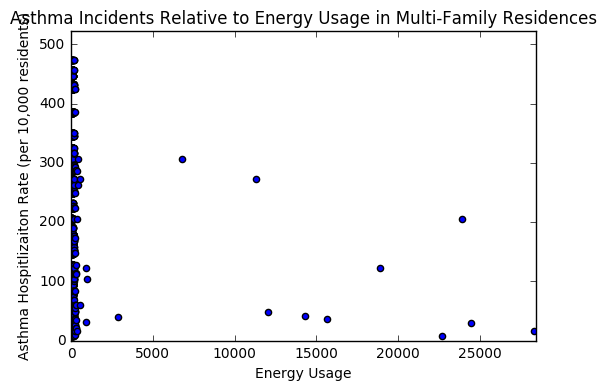

In [51]:
pl.title("Asthma Incidents Relative to Energy Usage in Multi-Family Residences")
pl.ylabel("Asthma Hospitlizaiton Rate (per 10,000 residents)")
pl.xlabel("Energy Usage")
pl.ylim(0,Residencies['ED Visit Rate'].max()+50)
pl.xlim(0,Residencies['Weather Normalized Site EUI (kBtu/ft^2)'].max()+100)
pl.scatter(Residencies['Weather Normalized Site EUI (kBtu/ft^2)'],
          Residencies['ED Visit Rate'])

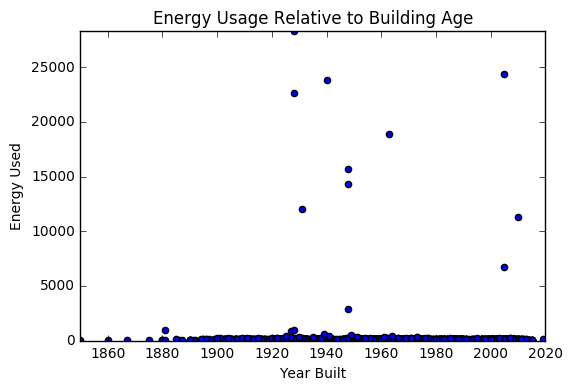

In [52]:
pl.title("Energy Usage Relative to Building Age")
pl.xlabel("Year Built")
pl.ylabel("Energy Used")
pl.xlim(1850, 2020)
pl.ylim(0,Residencies['Weather Normalized Site EUI (kBtu/ft^2)'].max()+50)
pl.scatter(Residencies['Year Built'], Residencies['Weather Normalized Site EUI (kBtu/ft^2)'])

In [53]:
Integrated.to_csv('Energy_Public_Health.xls', sheet_name="Integrated Dataset")

## <center>Mapping</center>

In [ ]:
from geopandas import GeoDataFrame
!curl -O "http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip"
os.rename("nycb2010_16d.zip", "nyc_census_shape_file.zip")
shapefile="nyc_census_shape_file.zip"
os.system("mv " + shapefile + " " + "Data/")
zf = zipfile.ZipFile("Data/" + shapefile, mode='r')
zf.extractall("Data/nyc_census_shape_file/")
zf.close()
shapefile =  "Data/nyc_census_shape_file/nycb2010_16d"

In [ ]:
shape_path = shapefile
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape['ct2010'] = ct_shape.BoroCode + ct_shape.CT2010
ct_shape.crs = from_epsg(2263) # epsg=4326: lat/on | epsg=2263 is US feet
ct_latlon=ct_shape.to_crs(epsg=4326)# from ft2 to mi2

In [ ]:
Integrated_map = pd.merge(ct_shape, Integrated, on='ct2010', how='inner')

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
Integrated_map.plot(ax=ax, column='ED Visit Rate', linewidth=0, alpha=.8, cmap='Reds')

#bk_ct[(bk_ct.BCTCB2010 == cusp_ct)].plot(alpha=.6, ax=ax, color='red')
#pl.scatter(CUSP.x, CUSP.y, color='blue', edgecolors='blue', linewidths=8, alpha=.5)
#plt.legend(handles=[radar_circle])

#ax.set_title("CUSP Location and an Assortment of 1/10 of Brooklyn's Census Tracts", fontsize='large')
#pl.figtext(0.1, -0.00000000001, '''The figure above depicts a random assortment of 1/10 of Brooklyn's census tracts. 
#CUSP is displayed as a red point located in tract %s. ''' %cusp_ct, 
#          fontsize='small')

In [ ]:
#Dependent : Ridership (Y)
#Independent: AGI (X)
#field names: zipcodes 	N 	Ndeps 	Njoint 	income 	incomePC 	NRides

#In example,  X = income
#             Y = NRides

#Using "cbjoinedafter", without outliers. 
pl.figure(figsize=(6 * 1.8, 6))
pl.scatter(cbjoinedafter.income, cbjoinedafter.NRides, alpha=0.4, color="green", label="Riders v. Income")
pl.xlabel('Income')
pl.ylabel('Number of Rides')
#pl.text(0, -20,'lower status of the population) against median value')
pl.ylim(0,)
pl.xlim(0,)
pl.title("CitiBike Ridership Relative to Income: June 2015")

# points linearlyd space on lstats from minimum to maximom, 100 points
x = pd.DataFrame({'income': np.linspace(cbjoinedafter.income.min(), cbjoinedafter.income.max(), 100)})
#linspace creates an array of a given number of elements evenly spaced between a minimum of maximum. 

# 1-st order polynomial #LINE FITTING
linear_line = smf.ols(formula='NRides ~ income + 1', data=cbjoinedafter).fit()
pl.plot(x.income, linear_line.predict(x), label='1st Degree Polynomial $R^2$=%.2f' % linear_line.rsquared, 
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='NRides ~ 1 + income + I(income ** 2.0)', data=cbjoinedafter).fit()
pl.plot(x.income, poly_2.predict(x), 'g-', label='Second Degree Polynomial $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

plt.legend()